<a href="https://colab.research.google.com/github/vivamoto/Data-Science/blob/main/TOTVS_Labs_Data_Science_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright information

Copyright © 2021 Victor Ivamoto

Licensed under the [MIT License](https://raw.githubusercontent.com/vivamoto/Unsupervised-Learning/main/LICENSE). You may not use this file except in compliance with the License.

# TOTVS Labs - Data Science Challenge

Source: https://github.com/totvslabs/datachallenge

The purpose of this challenge is to let you demonstrate the way you think and work. The [dataset](https://github.com/totvslabs/datachallenge/raw/master/challenge.zip) we are providing has two tables: 

1. `orders.json` contains the orders made by customers in one of our applications between '2008-Jan-04' and '2018-July-08'. These customers do not have any contracts or memberships whatsoever with the company and may stop or restart purchasing at will. Here's the description of each column:
    * `customer_code`: unique id of a customer;
    * `branch_id`: the branch id where this order was made;
    * `sales_channel`: the sales channel this order was made;
    * `seller_code`: seller that made this order;
    * `register_date`: date of the order;
    * `total_price`: total price of the order (sum of price of all items);
    * `order_id`: id of this order. A order is formed by a set of items;
    * `item_code`: code of the item;
    * `quantity`: quantity of items (of item_code) bought;
    * `item_total_price`: total price of items (of item_code), i.e., quantity* unit_price;
    * `unit_price`: unit price of this item (of item_code);
    * `group_code`: group this customer belongs;
    * `segment_code`: segment this customer belongs;

2. `is_churn.json` contains the 3 columns
    * `customer_code`: unique id of a customer;
    * `is_churn`: If the client is a churn on 2018-Aug-01.  
    * `last_purchase_date`: last purchase date. 
    
Notes:
- The primary key of the orders.json table is: `order_id` + `item_code`.
- `is_churn` was recorded for all customers on 2018-Aug-01 irrespective of when they actually churned prior to 2018-Aug-01. For example, let us say, Customer1 churns in 2010 and Customer2 churns in 2016. For both customers, the record of `is_churn=1(yes)` was made on 2018-Aug-01. 

There are many possible use cases for this dataset. For example, product recommendation, churn analysis, sales forecasting, etc.  Pick one use case and build a model for this case. We want to test your skills in data manipulation, cleaning, and predictive modeling. So, please explain all your design and analysis choices. You can use jupyter notebooks for all your exploration and modeling (e.g., EDA, preprocessing, model selection, hyperparameters, evaluation criteria, etc.). You shouldn't spend more than 5 hours to complete the exercise.

You can find the dataset for this challenge in the following url:
https://github.com/totvslabs/datachallenge/raw/master/challenge.zip

PS: Ideally, we should be able to replicate your analysis from your submitted source-code, so please explicit the versions of the tools and packages you are using.

 Please share the zip file of your solution privately OR share your private git repo containing the solution with us.


# Install and Import Libraries

In [110]:
!pip install sklearn pandas numpy minisom fuzzy-c-means
!pip install -U scikit-fuzzy
#!pip install fuzzy-c-means

Requirement already up-to-date: scikit-fuzzy in /usr/local/lib/python3.7/dist-packages (0.4.2)


In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import datetime           # Processing duration
import tqdm               # Progress bar

# Data preparation
import urllib.request     # Download dataset
import zipfile            # Unzip dataset
import os

# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Clustering 
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from minisom import MiniSom     # Self-Organizing Maps (SOM)
import skfuzzy as fuzz          # Fuzzy c-means
from fcmeans import FCM         # Fuzzy c-means

# Create folders used in this notebook
for folder in ['results', 'plots']:
  if not os.path.exists(folder):
    os.mkdir(folder)

# Data Cleaning

In this section we download and prepare the dataset for analysis. Data shall be clean, in tidy format and normalized. The analysis result is as good as the input data, so it's worth spending some time in this step.

## Download datasets

In [112]:
# Download and unzip
url = 'https://github.com/totvslabs/datachallenge/raw/master/challenge.zip'

orders_file = 'challenge/orders.json'
is_churn_file = 'challenge/is_churn.json'

# Download dataset only once
if not os.path.exists(orders_file):
  zip_path, _ = urllib.request.urlretrieve(url)
  with zipfile.ZipFile(zip_path, "r") as f:
      f.extractall('.')

# Load dataset
orders = pd.read_json(orders_file)
churn = pd.read_json(is_churn_file)

orders.head()

,customer_code,branch_id,sales_channel,seller_code,register_date,total_price,order_id,quantity,item_code,item_total_price,unit_price,group_code,segment_code
0,347,0,0,106,2018-01-22T00:00:00Z,2868.41,22589,2,1608,170.55,72.90,0,0
1,326,0,1,170,2011-01-29T00:00:00Z,4330.89,4897,3,373,211.60,64.12,0,0
2,601,0,0,3,2015-10-14T00:00:00Z,1842.92,15518,12,282,237.84,19.82,0,0
3,833,0,0,156,2016-03-30T00:00:00Z,6801.08,16568,20,1966,471.80,23.59,0,0
4,823,0,0,173,2017-05-17T00:00:00Z,3006.10,19774,2,750,186.58,93.29,0,0


In [113]:
churn.head()

,customer_code,last_purchase_date,is_churn
0,31,2018-05-23T00:00:00Z,0
1,560,2018-02-21T00:00:00Z,0
2,697,2018-06-12T00:00:00Z,0
3,438,2018-02-26T00:00:00Z,0
4,234,2018-02-08T00:00:00Z,1


## Summary Statistics
We get a feeling of the dataset looking at summary statistics. Most variables are numeric, except `register_date` and `last_purchase_date`.

In [114]:
orders.describe(include='all')

,customer_code,branch_id,sales_channel,seller_code,register_date,total_price,order_id,quantity,item_code,item_total_price,unit_price,group_code,segment_code
count,204428.000000,204428.0,204428.000000,204428.000000,204428,204428.000000,204428.000000,204428.000000,204428.000000,204428.000000,204428.000000,204428.000000,204428.000000
unique,NaN,NaN,NaN,NaN,3121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,2017-11-23T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,447.489062,0.0,1.761182,145.543022,NaN,5337.072931,12434.088863,12.332694,1437.298981,304.048244,47.456664,0.307184,0.846381
std,246.678026,0.0,2.929541,75.197609,NaN,21268.855032,6935.623011,53.299314,903.166319,1009.268287,145.295694,0.714639,1.615763
min,0.000000,0.0,0.000000,0.000000,NaN,0.010000,0.000000,1.000000,0.000000,0.000000,0.010000,0.000000,0.000000
25%,221.000000,0.0,0.000000,83.000000,NaN,1180.470000,6497.750000,3.000000,631.000000,79.600000,14.670000,0.000000,0.000000
50%,486.000000,0.0,0.000000,156.000000,NaN,2035.820000,12698.000000,6.000000,1455.000000,156.150000,21.780000,0.000000,0.000000
75%,651.000000,0.0,2.000000,195.000000,NaN,3611.070000,18280.000000,12.000000,2048.000000,293.862500,46.720000,0.000000,2.000000


In [115]:
churn.describe(include='all')

,customer_code,last_purchase_date,is_churn
count,818.000000,818,818.000000
unique,NaN,140,NaN
top,NaN,2018-05-23T00:00:00Z,NaN
freq,NaN,20,NaN
mean,418.254279,NaN,0.099022
std,242.113266,NaN,0.298874
min,0.000000,NaN,0.000000
25%,209.250000,NaN,0.000000
50%,419.500000,NaN,0.000000
75%,628.750000,NaN,0.000000


In [116]:
print('='*20, 'Orders dataset: count and dtype', '='*20)
print(orders.count(), '\n\n', orders.dtypes)

print('='*20, 'Churn dataset: count and dtype', '='*20)
print(churn.count(), '\n\n', churn.dtypes)

==================== Orders dataset: count and dtype ====================
customer_code       204428
branch_id           204428
sales_channel       204428
seller_code         204428
register_date       204428
total_price         204428
order_id            204428
quantity            204428
item_code           204428
item_total_price    204428
unit_price          204428
group_code          204428
segment_code        204428
dtype: int64 

 customer_code         int64
branch_id             int64
sales_channel         int64
seller_code           int64
register_date        object
total_price         float64
order_id              int64
quantity              int64
item_code             int64
item_total_price    float64
unit_price          float64
group_code            int64
segment_code          int64
dtype: object
==================== Churn dataset: count and dtype ====================
customer_code         818
last_purchase_date    818
is_churn              818
dtype: int64 

 customer_code 

## Near Zero Variance
Variables with zero or very low variance have low predictive power and may be excluded from the dataset. This procedure reduces the dimensionality and improves processing performance.

In [117]:
print('='*20, 'Orders dataset: variance and count unique values', '='*20)
print(orders.var() < 1e-1, '\n\n', orders.nunique())

print('='*20, 'Churn dataset: variance and count unique values', '='*20)
print(churn.var(), '\n\n', churn.nunique())

==================== Orders dataset: variance and count unique values ====================
customer_code       False
branch_id            True
sales_channel       False
seller_code         False
total_price         False
order_id            False
quantity            False
item_code           False
item_total_price    False
unit_price          False
group_code          False
segment_code        False
dtype: bool 

 customer_code         838
branch_id               1
sales_channel         106
seller_code           290
register_date        3121
total_price         22713
order_id            24618
quantity              290
item_code            2981
item_total_price    55336
unit_price          19828
group_code              4
segment_code            8
dtype: int64
==================== Churn dataset: variance and count unique values ====================
customer_code    58618.833672
is_churn             0.089326
dtype: float64 

 customer_code         818
last_purchase_date    140
is_churn   

The variable `branch_id` contains just one value and zero variance, so it'll be removed.

In [118]:
orders = orders.drop('branch_id', axis=1)
orders.head()

,customer_code,sales_channel,seller_code,register_date,total_price,order_id,quantity,item_code,item_total_price,unit_price,group_code,segment_code
0,347,0,106,2018-01-22T00:00:00Z,2868.41,22589,2,1608,170.55,72.90,0,0
1,326,1,170,2011-01-29T00:00:00Z,4330.89,4897,3,373,211.60,64.12,0,0
2,601,0,3,2015-10-14T00:00:00Z,1842.92,15518,12,282,237.84,19.82,0,0
3,833,0,156,2016-03-30T00:00:00Z,6801.08,16568,20,1966,471.80,23.59,0,0
4,823,0,173,2017-05-17T00:00:00Z,3006.10,19774,2,750,186.58,93.29,0,0


## Missing Values
Missing values is very commom in many datasets and must be addressed before building the model. First we detect the presence of missing values, so that we can handle accordingly.

In [119]:
print('='*20, 'Count NAs', '='*20)
print(orders.isna().sum(),'\n\n' , churn.isna().sum())
print('='*20, 'Count Nulls', '='*20)
print(orders.isnull().sum(),'\n\n' , churn.isnull().sum())

==================== Count NAs ====================
customer_code       0
sales_channel       0
seller_code         0
register_date       0
total_price         0
order_id            0
quantity            0
item_code           0
item_total_price    0
unit_price          0
group_code          0
segment_code        0
dtype: int64 

 customer_code         0
last_purchase_date    0
is_churn              0
dtype: int64
==================== Count Nulls ====================
customer_code       0
sales_channel       0
seller_code         0
register_date       0
total_price         0
order_id            0
quantity            0
item_code           0
item_total_price    0
unit_price          0
group_code          0
segment_code        0
dtype: int64 

 customer_code         0
last_purchase_date    0
is_churn              0
dtype: int64


## Combine Both Datasets
The combined dataset will be used inthe churn analysis, while the `orders` table is used to build a recommendation system and create the clusters.

In [120]:
# Count the number of customers in both tables
n_orders = len(orders.customer_code.unique())   # Count customers in 'orders' table
n_churn = churn.customer_code.count()           # Count customers in 'churn' table
dif = n_orders - n_churn                        # Difference in both tables
print('Number of customers in \'orders\' table:', n_orders)
print('Number of customers in \'churn\' table:',  n_churn)
print('Difference: {} ({}%)'.format(dif, np.round(100 * dif/n_orders, 2)))

# Combine orders and churn tables
df = pd.merge(orders, churn, on = "customer_code", how = "outer")
print('='*20, 'Variables Count in Combined Datasets' ,'='*20)
print(df.count())

# Show missing values
print('='*20, 'Missing Churn Information' ,'='*20)
missing_churn = df[df.is_churn.isna()].groupby('customer_code').size().reset_index(name='Count').sort_values(['Count'], ascending=False)
print(missing_churn)

Number of customers in 'orders' table: 838
Number of customers in 'churn' table: 818
Difference: 20 (2.39%)
==================== Variables Count in Combined Datasets ====================
customer_code         204428
sales_channel         204428
seller_code           204428
register_date         204428
total_price           204428
order_id              204428
quantity              204428
item_code             204428
item_total_price      204428
unit_price            204428
group_code            204428
segment_code          204428
last_purchase_date    202513
is_churn              202513
dtype: int64
==================== Missing Churn Information ====================
    customer_code  Count
14            623    308
16            721    270
18            792    258
12            527    200
7             319    154
2             161    112
19            834     97
15            625     85
13            529     74
6             313     73
0              16     56
10            404     48
4

Since the number of customers without churn information is small (2.4%) compared to the total number of customers, it's safe to drop these missing observations from `df` table.

In [121]:
# Drop rows in 'orders' table
for i in missing_churn.customer_code:
  df = df.drop(df[df['customer_code'] == i].index)

# Exploratory Data Analysis

## Univariate Analysis

### Prevalence of Churn

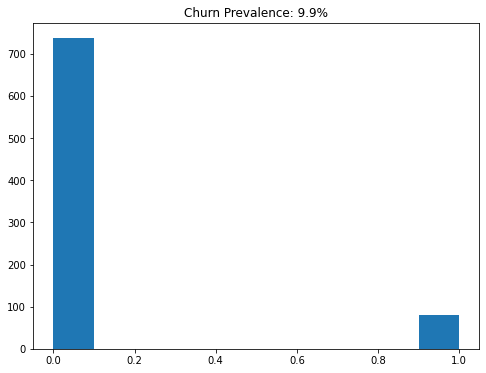

In [ ]:
# Prevalence of churn  
freq = np.round(100 * np.mean(churn.is_churn == 1), 2)

# Histogram
plt.figure(figsize = (8,6))
plt.hist(churn.is_churn)
plt.title('Churn Prevalence: {}%'.format(freq))
plt.savefig('plots/churn_prevalence.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Histograms

The histogram shows concentration of sales in:
- a few number of channels
- lower price range
- quantity
- item total price
- unit price
- group code
- segment code

The X axis range for these variables indicate the presence of outliers. The histogram bars are so small compared with the dominant bin that doesn't appear on the chart, except for `group_code` and `segment_code` variables.

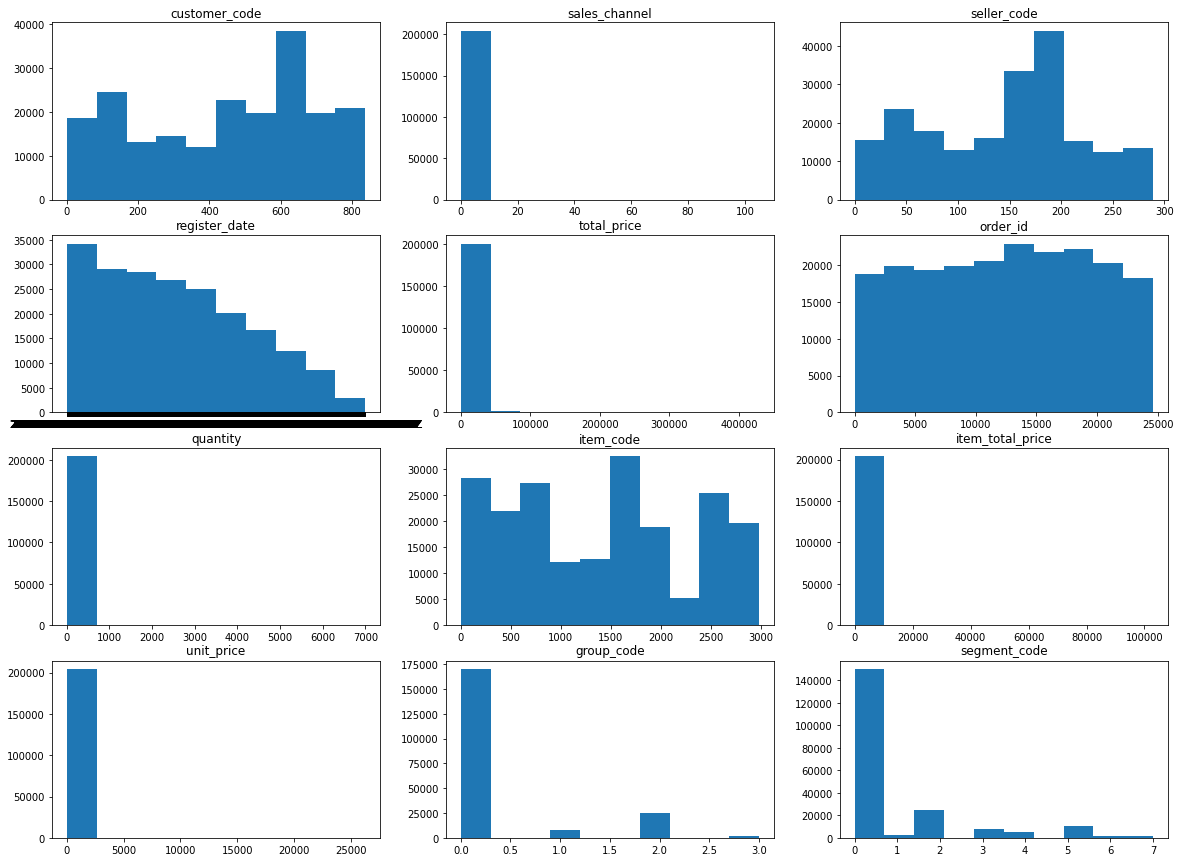

In [ ]:
plt.figure(figsize = (20, 15))

for i, col_name in enumerate(orders.columns):
    plt.subplot(4, 3, i+1)
    plt.hist(orders.iloc[:,i])
    plt.title(col_name)
    i+=1
plt.savefig('plots/histograms.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Outliers

The presence of outliers is readily available from the histograms. 

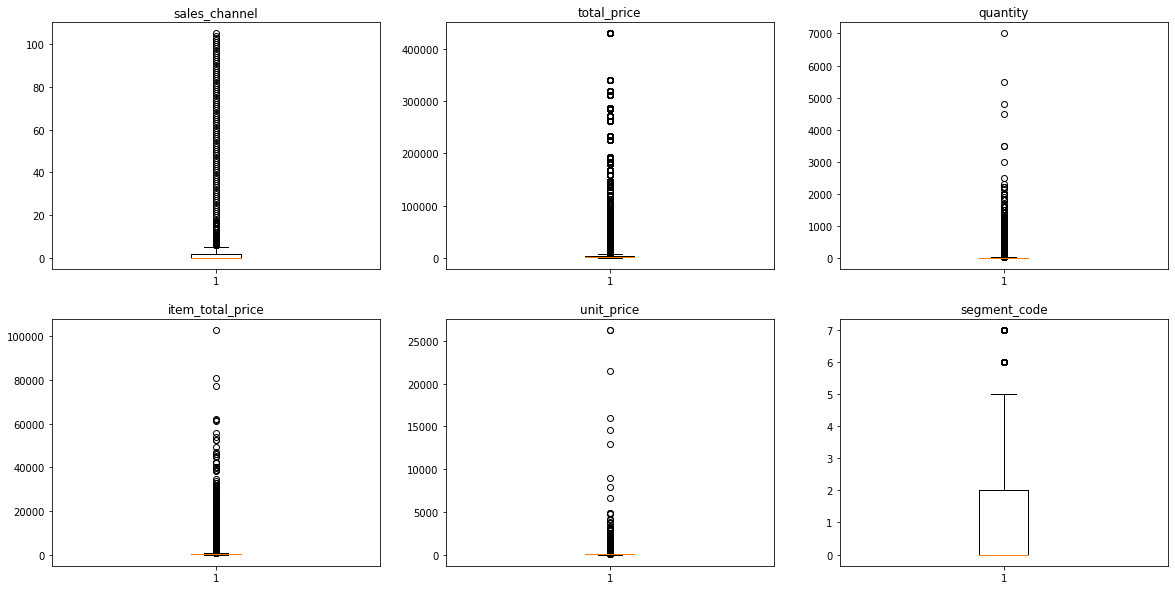

In [ ]:
cols = ['sales_channel', 'total_price', 'quantity', 'item_total_price', 'unit_price', 'segment_code']

plt.figure(figsize = (20, 10))
for i, col_name in enumerate(cols):
    plt.subplot(2, 3, i+1)
    plt.boxplot(orders[col_name])
    plt.title(col_name)
    i+=1
plt.savefig('plots/outliers.png', dpi = 300, bbox_inches = 'tight')    
plt.show()

In [ ]:
# Sales channel, group code and segment code are categorical variables
# Price is continuous variable
# Quantity is discrete variable
cols = ['sales_channel', 'total_price', 'quantity', 'item_total_price', 'unit_price', 'group_code', 'segment_code']
cats = ['sales_channel', 'group_code', 'segment_code']      # Categorical variables
cnts = ['total_price', 'item_total_price', 'unit_price']    # Continuous variables
disc = ['quantity']  # Discrete variable
['customer_code', 'seller_code', 'item_code']

#for col in cols:
  #orders
#orders['sales_channel']
#orders.groupby('sales_channel').size().reset_index(name='Number of orders'). \
#              sort_values(['Number of orders'], ascending=False).head(10)
for col in cols:
  print('='*20, col, '='*20)
  print(orders.groupby(col).size().reset_index(name='Count').sort_values(['Count'], ascending=False).head(20))



==================== sales_channel ====================
    sales_channel   Count
0               0  103960
1               1   47961
6               6   25960
7               7   11355
2               2    6068
8               8    4655
4               4    3483
9               9     463
5               5     204
10             10      76
16             16      71
14             14      42
11             11      13
12             12      10
3               3      10
17             17       6
15             15       2
77             77       1
74             74       1
75             75       1
==================== total_price ====================
       total_price  Count
18981      3117.48    138
19521      3419.71     91
22703    233010.15     87
22503     19427.21     85
22707    284662.05     83
22522     21431.25     79
20900      4691.30     77
22708    286607.34     73
6954        959.53     72
22591     35384.23     71
22712    428976.46     71
22702    226159.04     70
20115 

## Multivariate Analysis

### Correlation Matrix
The correlation matrix shows that `is_churn` has high correlation with `group_code`.

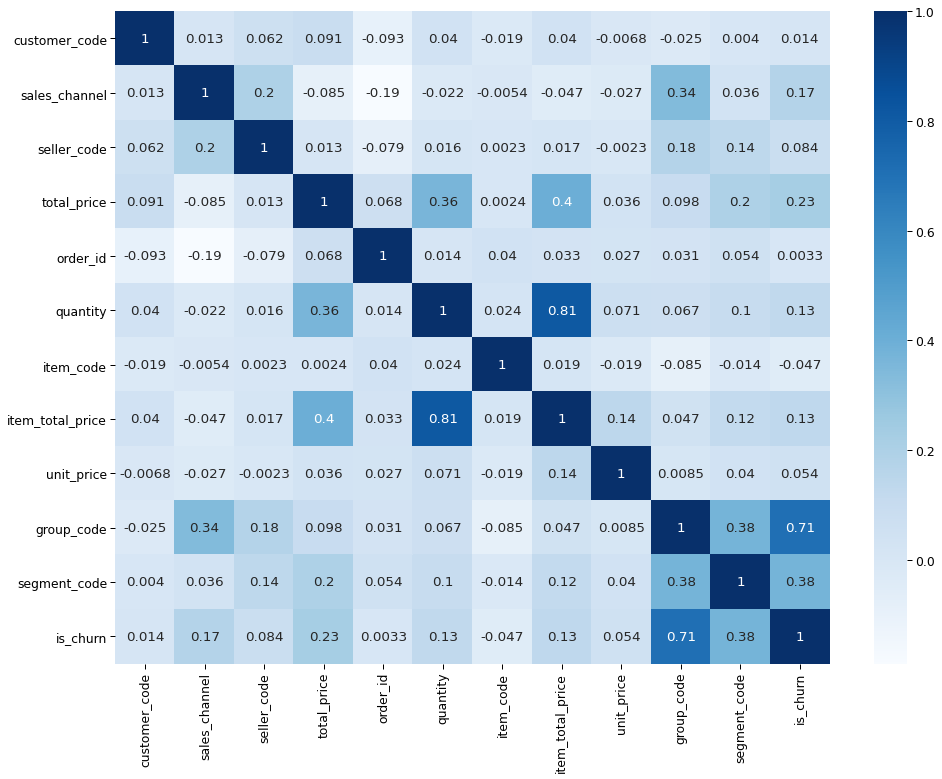

In [168]:
plt.figure(figsize=(16, 12))
sns.set_context('paper', font_scale = 1.4)

cor_matrix = df.corr()
sns.heatmap(cor_matrix, annot = True, cmap = 'Blues')
plt.savefig('plots/correlation_matrix.png', dpi = 300, bbox_inches = 'tight')

### Correlogram

No handles with labels found to put in legend.


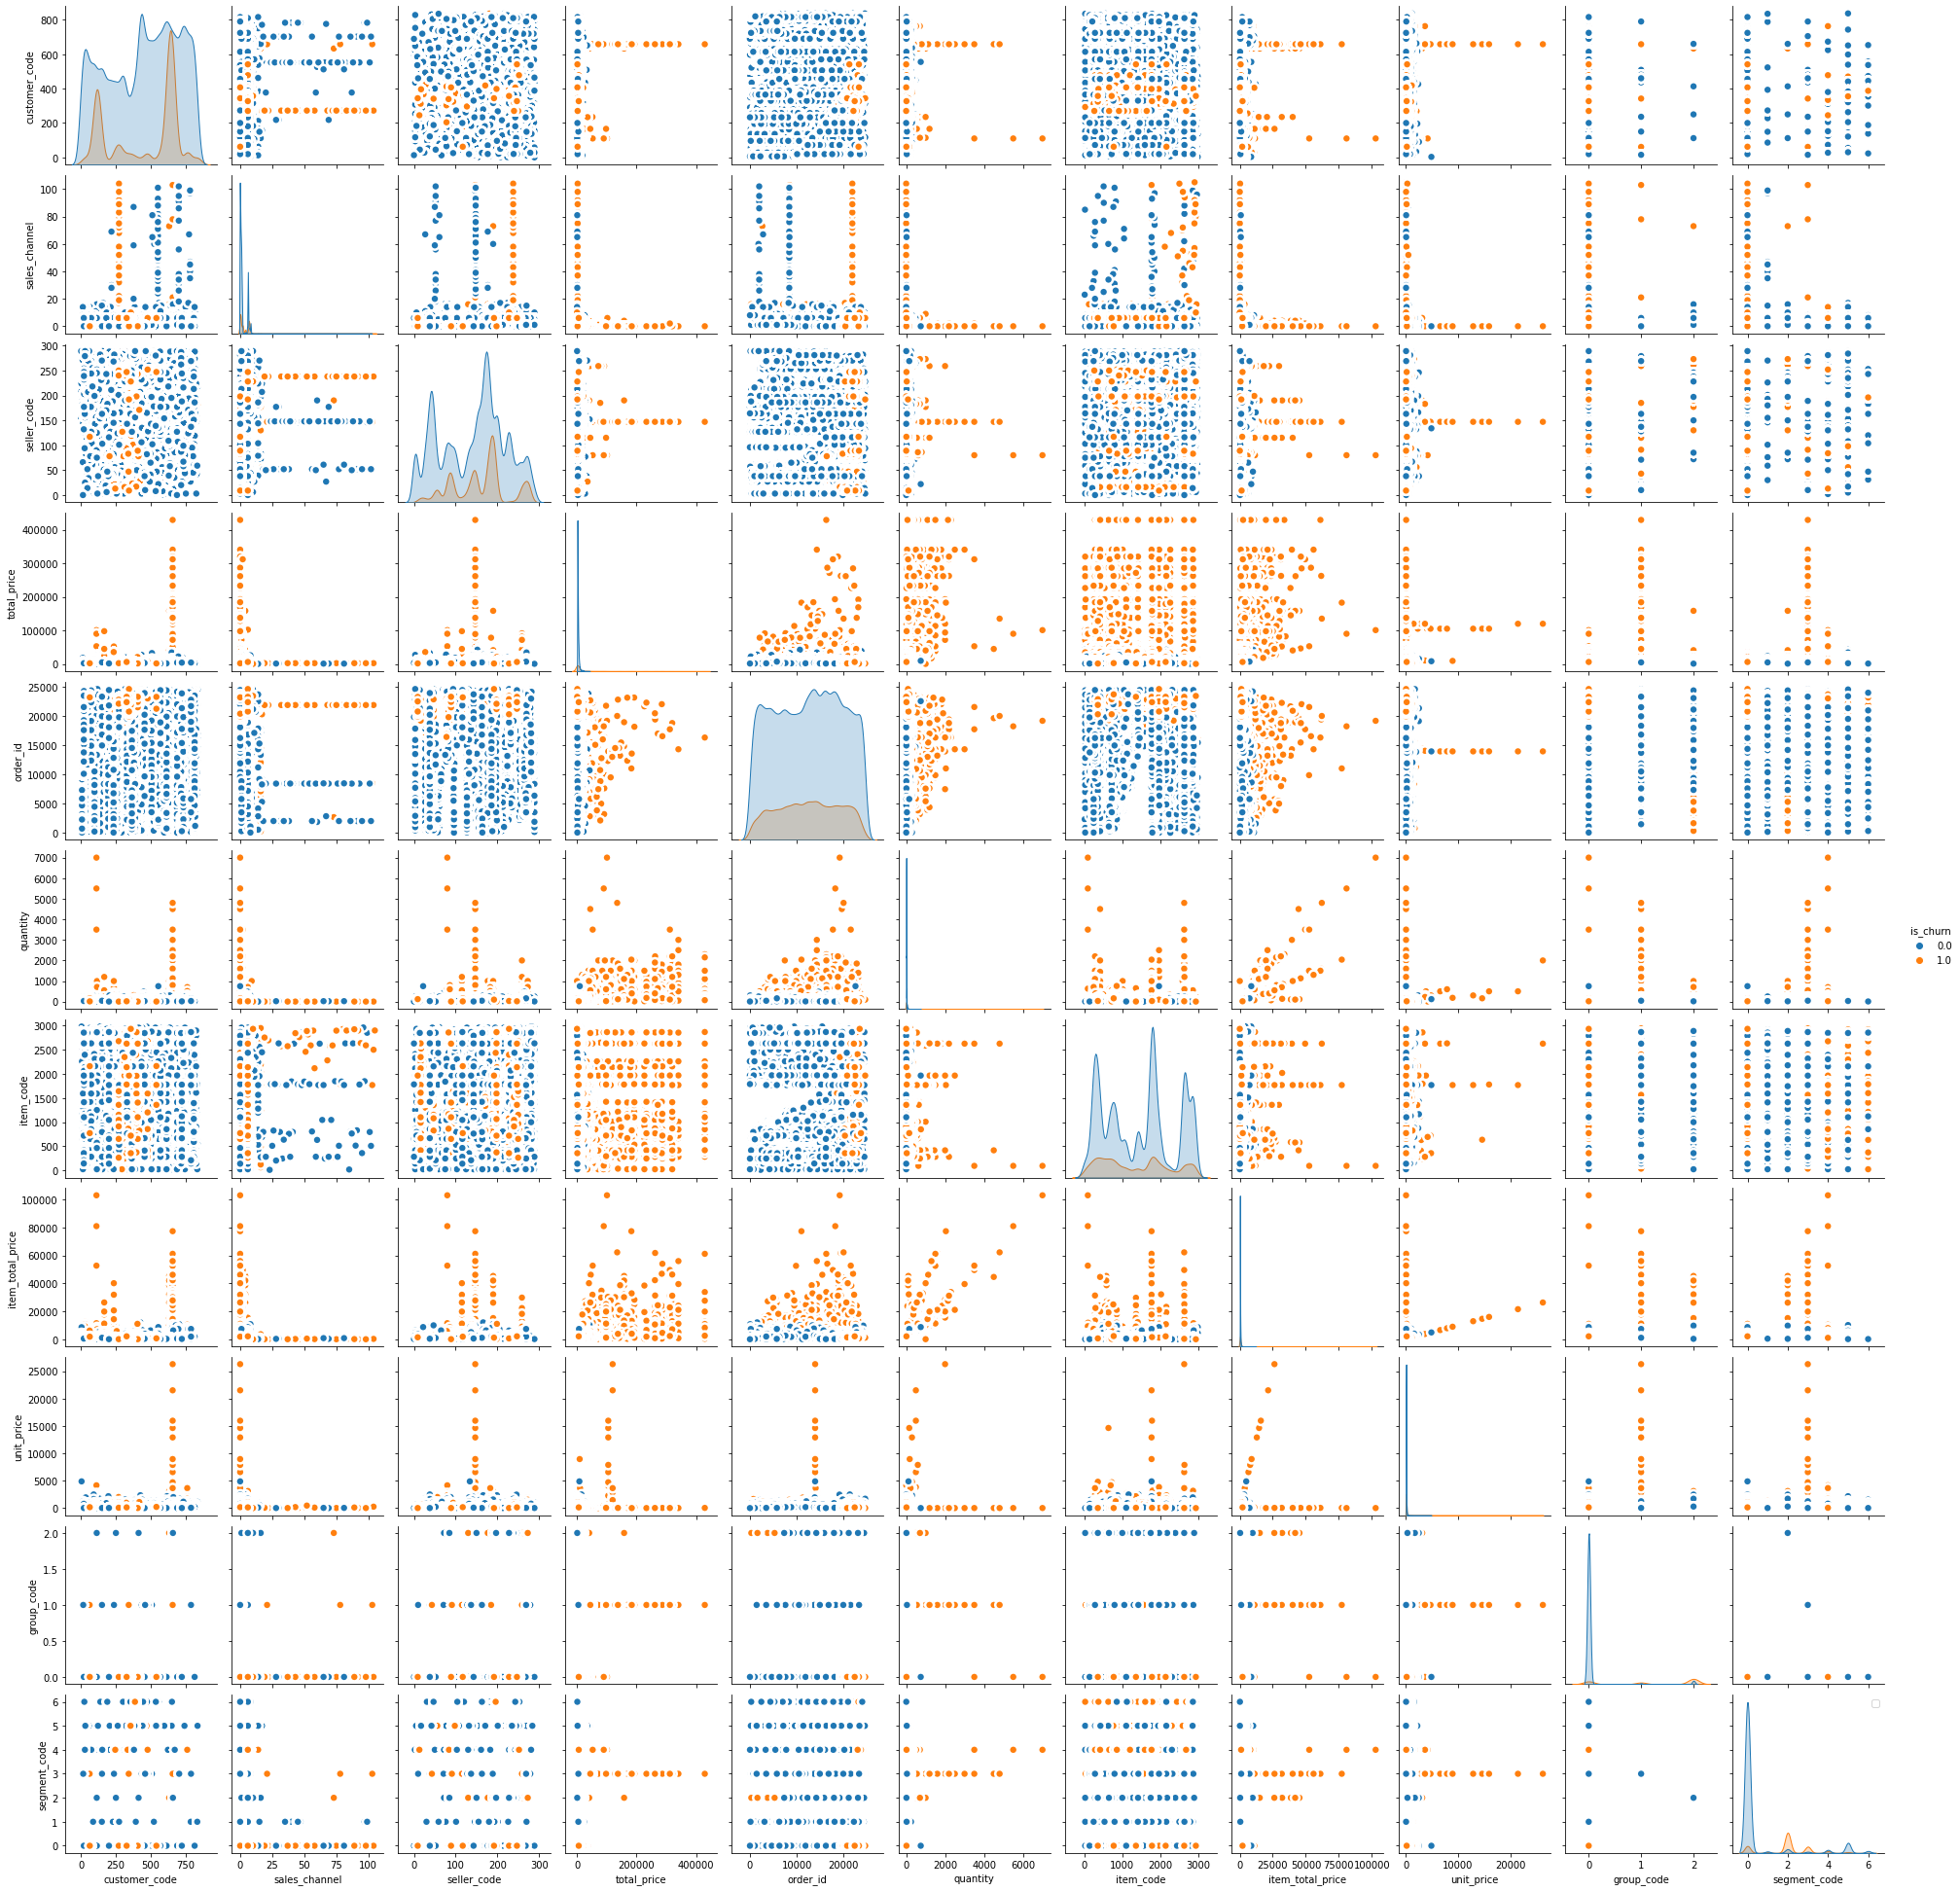

In [105]:
sns.pairplot(df, kind="scatter", hue="is_churn", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.legend()
plt.savefig('plots/correlogram.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Customer vs Seller Distribution

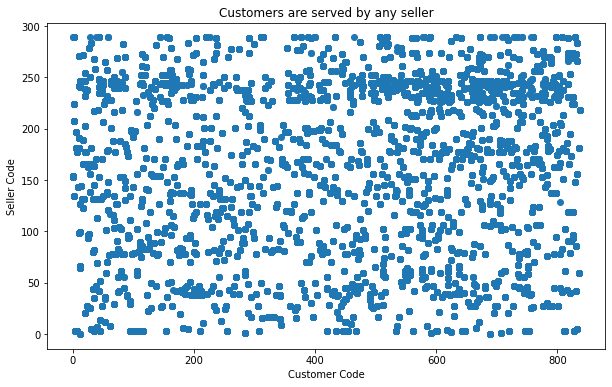

In [ ]:
plt.figure(figsize = (10, 6))
plt.scatter(df['customer_code'], df['seller_code'])
plt.title('Customers are served by any seller')
plt.xlabel('Customer Code')
plt.ylabel('Seller Code')
plt.savefig('plots/customers_by_seller.png', dpi = 300, bbox_inches = 'tight')
plt.show()

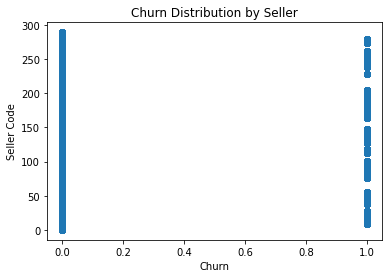

In [ ]:
plt.figure()
plt.scatter(df['is_churn'], df['seller_code'])
plt.title('Churn Distribution by Seller')
plt.xlabel('Churn')
plt.ylabel('Seller Code')
plt.savefig('plots/churn_by_seller.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
# Churn happened with these sellers
churn_seller = df[df.is_churn == 1].seller_code.unique()
print('Count of sellers:', len(churn_seller))
churn_seller

Count of sellers: 68


array([177, 190,  56,  80,  16,  39, 143, 181, 259, 147, 185,  50,  86,
       130, 273, 261, 166,  82,  95, 138, 250,  40, 183, 188,  17, 115,
       204, 247, 243,  38, 163, 279, 198,  15,  91,  27, 113,  43,  76,
       238,  98,   8, 101,  79, 201,  78, 199,  28,  13,  84,  23, 134,
       196, 119, 228, 245, 240,  47, 187, 252,  94, 127, 171,  83,  89,
         9, 192, 117])

In [ ]:
# These sellers had churn and no churn
df[df.is_churn == 0].seller_code[churn_seller].unique()

array([170, 106])

# Churn Analysis

## Data Preparation

In [122]:
# Normalization: center and scale
cols = ['customer_code', 'sales_channel', 'seller_code', 
       'total_price', 'order_id', 'quantity', 'item_code', 'item_total_price',
       'unit_price', 'group_code', 'segment_code']
       
X = np.array(df[cols])
X_scaled = (X - np.mean(X)) / np.std(X)

y = np.array(df.is_churn)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

## Feature Selection

In [123]:
# Tree-based feature selection
clf = ExtraTreesClassifier()
model = SelectFromModel(clf, threshold='median').fit(X_train, y_train)
# Reduce X_train and X_test to the selected features
X_train = model.transform(X_train)
X_test = model.transform(X_test)

print('Selected features:')
print(np.array(cols)[model.get_support()])


Best features:
['customer_code' 'seller_code' 'total_price' 'order_id' 'group_code'
 'segment_code']


## Parameter tuning

In [181]:
def std_format(num):
  return np.round(100 * num, 2)

# Result table
results = pd.DataFrame(columns = ['Model', 'Train Accuracy (%)',  
                                  'Test Accuracy (%)', 'Precision', 'Recall',
                                  'F1 score', 'ROC AUC', 'Duration', 'Best Parameters'])

models = {'LOG': {'name': 'Logistic Regression',
                  'model': LogisticRegression(),
                  'params': {'C' : [0, 1, 2, 3, 4],
                             'penalty' : ['l1', 'l2'],
                             'solver': ['saga'], 'tol': [1e-2], 
                             'max_iter': [200]}},
          'KNN': {'name': 'K Nearest Neighbors',
                  'model': KNeighborsClassifier(),
                  'params': {'n_neighbors': [5, 10, 15], 
                             'leaf_size': [30, 40],
                             'p': [1, 2],
                             'metric': ['minkowski']}},
          'RF':  {'name': 'Random Forest',
                  'model': ExtraTreesClassifier(),
                  'params': {'n_estimators': [50, 100, 150, 200]}},
          'GB':  {'name': 'Gradient Boosting',
                  'model': GradientBoostingClassifier(),
                  'params': {'n_estimators': [100, 200, 300]}},
          'MLP': {'name': 'Multilayer Perceptron',
                  'model': MLPClassifier(),
                  'params': {'hidden_layer_sizes': [(100), (100, 10)],
                             'activation': ['logistic']}}}

best_estimators = {}

st = datetime.datetime.now()  # start processing time
print('Start time: ', st)

# Execute all models
for model in ['LOG', 'KNN', 'RF', 'GB', 'MLP']:
    print('Processing model: {}'.format(models[model]['name']))
    
    start_time = datetime.datetime.now()

    # Parameter tuning
    estimator = models[model]['model']
    param = models[model]['params']
    clf = GridSearchCV(estimator = estimator , param_grid = param, 
                        scoring = 'roc_auc', n_jobs = -1, refit = 'roc_auc')
    clf.fit(X_train, y_train)

    best_estimators[model] = clf.best_estimator_
    # Compute Train Accuracy
    y_hat = clf.predict(X_train)
    train_acc = std_format(np.mean(y_train[:] == y_hat))
    
    # Compute Test Accuracy
    y_hat = clf.predict(X_test)
    test_acc = std_format(np.mean(y_test[:] == y_hat))
    
    # Confusion Matrix
    TP = np.sum(y_test[y_hat == 1])        # True Positive
    FP = np.sum(y_hat[y_test == 0])        # False Positive
    TN = np.sum(1 - y_test[y_hat == 0])    # True Negative
    FN = np.sum(1 - y_hat[y_test == 1])    # False Negative

    # Precision, Recall and F1-Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    y_score = clf.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, y_score)

    # Update result table
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    results.loc[len(results) + 1] = [models[model]['name'], train_acc, test_acc, std_format(precision), 
                                     std_format(recall), std_format(f1), std_format(roc),
                                     duration, clf.best_params_]

    print('{}:, Train accuracy: {}, test accuracy: {}, precision: {}, recall: {}, F1: {}, ROC_AUC: {}'.\
          format(models[model]['name'], train_acc, test_acc, std_format(precision), 
                 std_format(recall), std_format(f1), std_format(roc)))
    print('{} duration: {}'.format(model, duration))

et = datetime.datetime.now()

# Save results table
results.to_csv("results/results_{}.csv".format(et.strftime("%Y-%m-%d_%H-%M-%S")),
               sep='\t', index=False)

print(results.iloc[:,:-1])

print('End time:', et)
print('Duration:', et - st)  

Start time:  2021-03-02 19:22:59.596949
Processing model: Logistic Regression
Logistic Regression:, Train accuracy: 82.92, test accuracy: 82.62, precision: 96.88, recall: 9.84, F1: 17.87, ROC_AUC: 44.78
LOG duration: 0:02:02.125770
Processing model: K Nearest Neighbors
K Nearest Neighbors:, Train accuracy: 99.04, test accuracy: 98.09, precision: 95.31, recall: 94.71, F1: 95.01, ROC_AUC: 99.36
KNN duration: 0:00:38.431703
Processing model: Random Forest
Random Forest:, Train accuracy: 100.0, test accuracy: 100.0, precision: 100.0, recall: 100.0, F1: 100.0, ROC_AUC: 100.0
RF duration: 0:01:45.058738
Processing model: Gradient Boosting
Gradient Boosting:, Train accuracy: 99.6, test accuracy: 99.58, precision: 99.83, recall: 97.96, F1: 98.88, ROC_AUC: 99.97
GB duration: 0:06:25.116170
Processing model: Multilayer Perceptron
Multilayer Perceptron:, Train accuracy: 85.23, test accuracy: 85.04, precision: 78.58, recall: 30.45, F1: 43.89, ROC_AUC: 77.83
MLP duration: 0:11:10.982376
           

In [175]:
results

,Model,Train Accuracy (%),Test Accuracy (%),Precision,Recall,F1 score,ROC AUC,Duration,Best Parameters
1,Logistic Regression,82.92,82.62,96.88,9.84,17.87,44.78,0 days 00:02:04.500882,"{'C': 4, 'max_iter': 200, 'penalty': 'l1', 'so..."
2,K Nearest Neighbors,99.04,98.09,95.31,94.71,95.01,99.36,0 days 00:00:41.572871,"{'leaf_size': 30, 'metric': 'minkowski', 'n_ne..."
3,Random Forest,100.00,100.00,100.00,100.00,100.00,100.00,0 days 00:01:51.239009,{'n_estimators': 100}
4,Gradient Boosting,99.60,99.58,99.83,97.96,98.88,99.97,0 days 00:06:26.839925,{'n_estimators': 300}
5,Multilayer Perceptron,85.28,85.12,77.62,31.70,45.01,77.68,0 days 00:09:25.999171,"{'activation': 'logistic', 'hidden_layer_sizes..."


Ramdom forest achieved the highest score.

## Plots

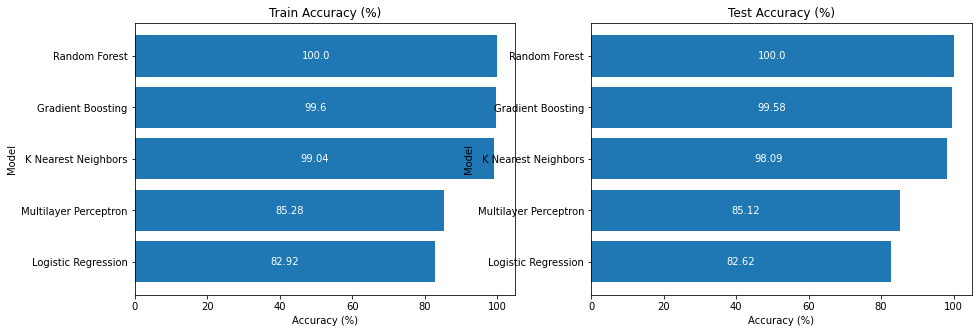

In [165]:
#========================================
# Create bar charts 
#========================================
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

cols = ['Train Accuracy (%)', 'Test Accuracy (%)']
axs = [ax1, ax2]

for col, ax in zip(cols, axs):
  tbl = results.sort_values(col, ascending=True)
  vals = tbl[col]
  y_pos = np.arange(len(vals))
  ax.barh(y_pos, vals, align='center', label = vals)
  ax.set_yticks(y_pos)
  ax.set_yticklabels(tbl['Model'])
  ax.set_title(col)
  ax.set_xlabel('Accuracy (%)')
  ax.set_ylabel('Model')
  for y, x in enumerate(vals):
    ax.text(x/2, y, np.round(x, 2), ha='center', va='center', color ='white')

# Save and show plot
plt.savefig('plots/churn_model_plots.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()


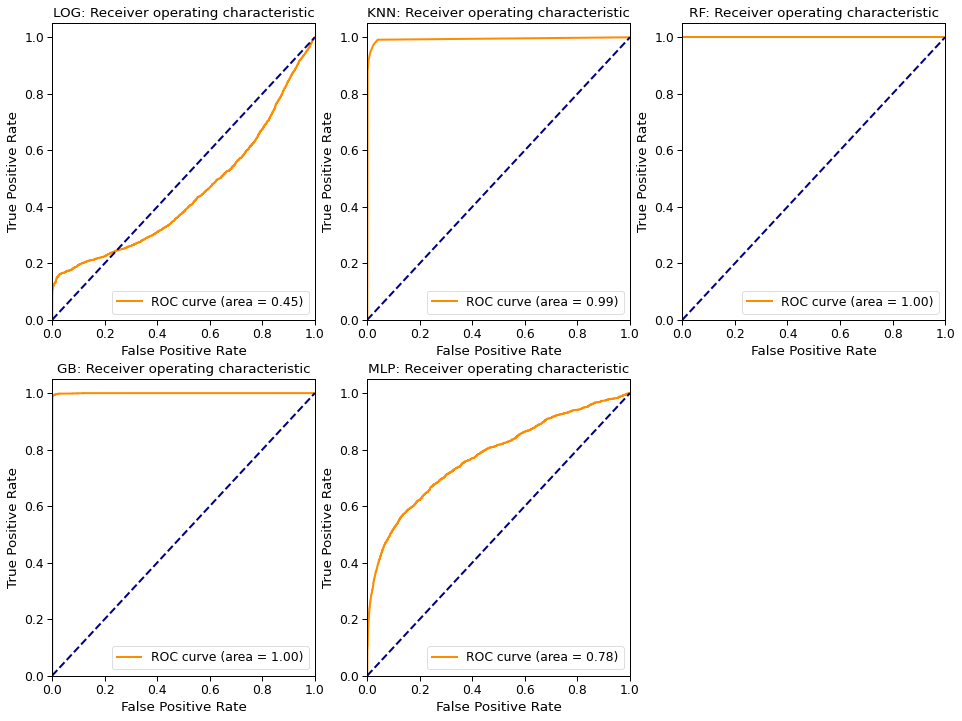

In [194]:
n = len(best_estimators)
nrows, ncols = np.ceil(n / 3), 3

plt.figure(figsize = (16, 6*nrows))

for i, model in enumerate(best_estimators):
  clf = best_estimators[model]
  y_score = clf.predict_proba(X_test)[:,1]

  # Compute ROC curve and ROC area for each class
  fpr, tpr, _ = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)

  lw = 2
  plt.subplot(nrows, ncols, i+1)
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('{}: Receiver operating characteristic'.format(model))
  plt.legend(loc="lower right")
  plt.savefig('plots/churn_roc_{}.png'.format(model), dpi = 300, bbox_inches = 'tight')

plt.show()

# Clustering

## DBSCAN

In [ ]:
cols = ['customer_code', 'sales_channel', 'seller_code', 
       'total_price',  'order_id', 'quantity', 'item_code', 'item_total_price',
       'unit_price', 'group_code', 'segment_code']
       
X = np.array(orders[cols])

db = DBSCAN(eps=3, min_samples=2).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 5824
Estimated number of noise points: 191570


## K-Means
K-Means clustering requires the definition of the number of clusters.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

print(kmeans.labels_, kmeans.cluster_centers_)


[0 0 0 ... 0 0 0] [[4.45869861e+02 1.77418210e+00 1.45530752e+02 3.70504581e+03
  1.23986156e+04 1.09132831e+01 1.43706909e+03 2.75144180e+02
  4.69698778e+01 3.01828291e-01 8.29834325e-01]
 [6.57919923e+02 7.17488789e-02 1.47137732e+02 2.17434732e+05
  1.70441819e+04 1.96798847e+02 1.46717489e+03 4.06041003e+03
  1.10719276e+02 1.00320307e+00 2.99679693e+00]]


## Self-Organizing Maps (SOM)

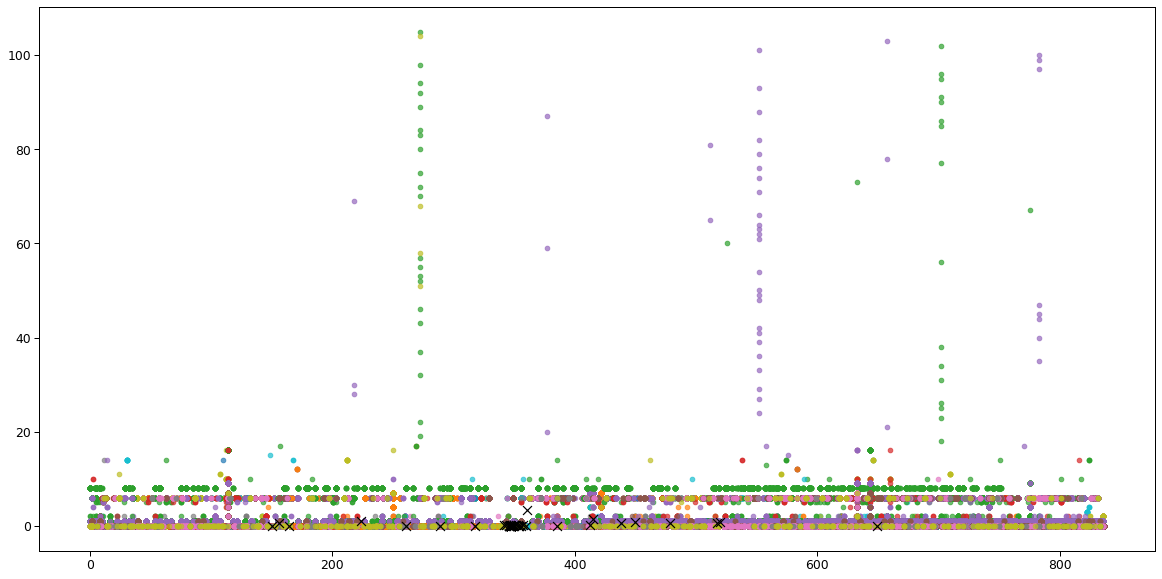

In [169]:
### Initialization and training ###
#som = MiniSom(6, 6, 4, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
#som.train(data, 100) # trains the SOM with 100 iterations

som_shape = (7, 7)
som = MiniSom(7,7,11,sigma=1.0,neighborhood_function='gaussian',learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X,100) # training with 100 iterations

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(i) for i in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

plt.figure(figsize = (20, 10))
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(X[cluster_index == c, 0],
                X[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')

plt.savefig('plots/cluster_som.png', dpi = 300, bbox_inches = 'tight')

## Fuzzy Clustering

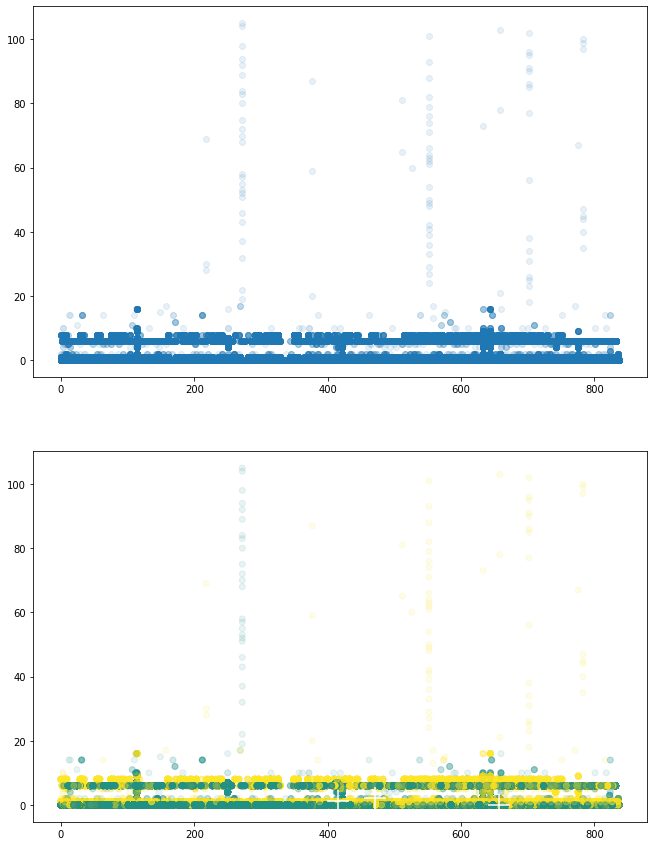

In [167]:
fcm = FCM(n_clusters=3)
fcm.fit(X)

# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)

# plot result
f, axes = plt.subplots(2, 1, figsize=(11, 15))
axes[0].scatter(X[:,0], X[:,1], alpha=.1)
axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='w')
plt.savefig('plots/cluster_fuzzy.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
fcm_centers, fcm_labels

(Buffer([[4.7259061e+02, 2.2828548e+00, 1.5267149e+02, 3.0012053e+03,
          6.0282231e+03, 1.0279568e+01, 1.3968475e+03, 2.4375992e+02,
          4.0281002e+01, 2.8050798e-01, 7.2870237e-01],
         [6.5736395e+02, 9.4618879e-02, 1.4734019e+02, 2.3141486e+05,
          1.7747580e+04, 1.9281778e+02, 1.4610753e+03, 4.0309727e+03,
          5.5571251e+01, 1.0017452e+00, 2.9981229e+00],
         [4.1642078e+02, 1.3629788e+00, 1.3806500e+02, 3.4231313e+03,
          1.8385514e+04, 9.8301525e+00, 1.4809639e+03, 2.6574390e+02,
          5.0172024e+01, 3.0471480e-01, 8.5008693e-01]], dtype=float32),
 DeviceArray([2, 0, 2, ..., 2, 2, 2], dtype=int32))

# Download Plots and Results

In [ ]:
%%bash
# List 'plots' and 'results' folder
ls -lh plots

echo
echo results directory:
ls -lh results

In [197]:
# Download results and plots
import glob
try:
  from google.colab import files
except ImportError:
  pass
else:
  for fname in glob.glob('plots/*'):
    files.download(fname)
  for fname in glob.glob('results/*'):
    files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# System Information

## Hardware Information

In [ ]:
!apt install lshw

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpci3 pciutils usbutils
The following NEW packages will be installed:
  libpci3 lshw pciutils usbutils
0 upgraded, 4 newly installed, 0 to remove and 11 not upgraded.
Need to get 723 kB of archives.
After this operation, 2,883 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpci3 amd64 1:3.5.2-1ubuntu1.1 [24.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 lshw amd64 02.18-0.1ubuntu6.18.04.2 [234 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 pciutils amd64 1:3.5.2-1ubuntu1.1 [257 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 usbutils amd64 1:007-4build1 [208 kB]
Fetched 723 kB in 1s (551 kB/s)
Selecting previously unselected package libpci3:amd64.
(Reading database ... 149414 files and directories currently installed

In [ ]:
%%bash
echo ========================
echo Memory Info \(GB\):
echo ========================
free -g

echo ========================
echo CPU Info:
echo ========================
lscpu

echo ========================
echo Disk space
echo ========================
df -h

echo ========================
echo Linux version
echo ========================
lsb_release -a

echo ========================
echo GPU
echo ========================
nvidia-smi

echo
lshw -C display

Memory Info (GB):
              total        used        free      shared  buff/cache   available
Mem:             12           1           8           0           2          11
Swap:             0           0           0
CPU Info:
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             1999.999
BogoMIPS:            3999.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall 

No LSB modules are available.


## Software Version

In [198]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import torch
import h5py
print('='*20, 'Software version', '='*20)
print("Python:", sys.version.split('\n')[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print('Matplotlib:', mpl.__version__)
print('Seaborn:', sns.__version__)
print("Sklearn:", sk.__version__)
print("Tensorflow:", tf.__version__)
print("Pytorch:", torch.__version__)
print("h5py:", h5py.__version__)

==================== Software version ====================
Python: 3.7.10 (default, Feb 20 2021, 21:17:23) 
NumPy: 1.19.5
Pandas: 1.1.5
Matplotlib: 3.2.2
Seaborn: 0.11.1
Sklearn: 0.22.2.post1
Tensorflow: 2.4.1
Pytorch: 1.7.1+cu101
h5py: 2.10.0
